Gen 1/10 - Promedio=0.9494, Mejor=0.9538
Gen 2/10 - Promedio=0.9514, Mejor=0.9560
Gen 3/10 - Promedio=0.9527, Mejor=0.9560
Gen 4/10 - Promedio=0.9556, Mejor=0.9582
Gen 5/10 - Promedio=0.9563, Mejor=0.9582
Gen 6/10 - Promedio=0.9574, Mejor=0.9604
Gen 7/10 - Promedio=0.9556, Mejor=0.9582
Gen 8/10 - Promedio=0.9556, Mejor=0.9582
Gen 9/10 - Promedio=0.9554, Mejor=0.9582
Gen 10/10 - Promedio=0.9549, Mejor=0.9582

Mejor fitness (CV accuracy): 0.9604246543511096
Mejores hiperparámetros encontrados: {'n_estimators': 141, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 1}
Accuracy en test: 0.9473684210526315


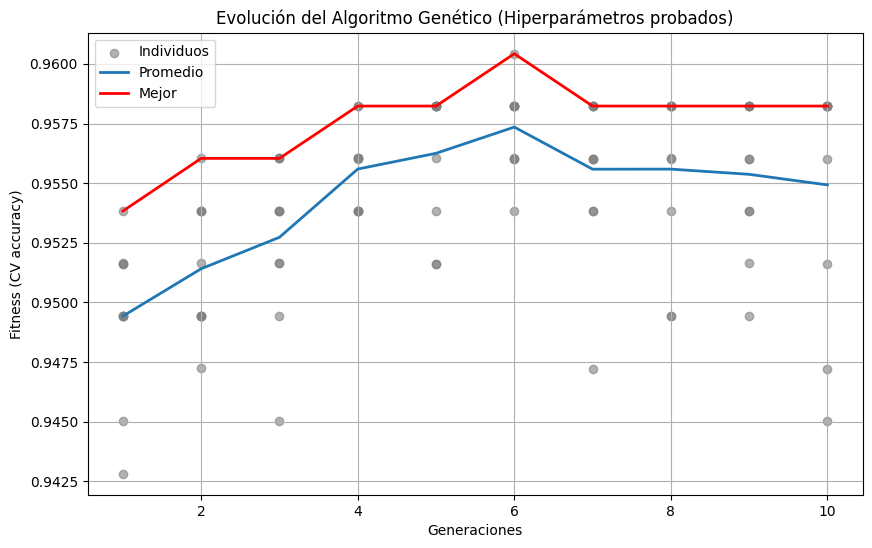

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# -------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# -------------------------
# Cargar datos
data = load_breast_cancer()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# -------------------------
# Algoritmo Genético
def crear_individuo():
    return {
        "n_estimators": np.random.randint(50, 300),
        "max_depth": np.random.randint(2, 20),
        "min_samples_split": np.random.randint(2, 10),
        "min_samples_leaf": np.random.randint(1, 5)
    }

def fitness(individuo, cv=3):
    modelo = RandomForestClassifier(
        n_estimators=individuo["n_estimators"],
        max_depth=individuo["max_depth"],
        min_samples_split=individuo["min_samples_split"],
        min_samples_leaf=individuo["min_samples_leaf"],
        random_state=SEED,
        n_jobs=-1
    )
    return cross_val_score(modelo, X_train, y_train, cv=cv, n_jobs=-1).mean()

def seleccion_torneo(poblacion, fitnesses, k=3):
    seleccionados = []
    for _ in range(len(poblacion)):
        idxs = np.random.choice(len(poblacion), k, replace=False)
        mejor = idxs[np.argmax([fitnesses[i] for i in idxs])]
        seleccionados.append(deepcopy(poblacion[mejor]))
    return seleccionados

def cruzamiento(p1, p2, tasa=0.8):
    if np.random.rand() < tasa:
        hijo1, hijo2 = deepcopy(p1), deepcopy(p2)
        for k in p1.keys():
            if np.random.rand() < 0.5:
                hijo1[k], hijo2[k] = hijo2[k], hijo1[k]
        return hijo1, hijo2
    return deepcopy(p1), deepcopy(p2)

def mutacion(individuo, tasa=0.2):
    nuevo = deepcopy(individuo)
    if np.random.rand() < tasa:
        nuevo["n_estimators"] = np.random.randint(50, 300)
    if np.random.rand() < tasa:
        nuevo["max_depth"] = np.random.randint(2, 20)
    if np.random.rand() < tasa:
        nuevo["min_samples_split"] = np.random.randint(2, 10)
    if np.random.rand() < tasa:
        nuevo["min_samples_leaf"] = np.random.randint(1, 5)
    return nuevo

def ejecutar_ga(pob_size=10, generaciones=10):
    poblacion = [crear_individuo() for _ in range(pob_size)]
    mejor, mejor_fit = None, -np.inf
    historial = []
    registros = []

    for g in range(generaciones):
        fitnesses = [fitness(ind) for ind in poblacion]

        prom, max_fit = np.mean(fitnesses), np.max(fitnesses)
        historial.append((prom, max_fit))

        if max_fit > mejor_fit:
            mejor_fit = max_fit
            mejor = deepcopy(poblacion[np.argmax(fitnesses)])

        # ✅ Mostrar en consola estilo Gen x/n
        print(f"Gen {g+1}/{generaciones} - Promedio={prom:.4f}, Mejor={max_fit:.4f}")

        # Guardar todos los individuos
        for ind, fit in zip(poblacion, fitnesses):
            registros.append({
                "Generacion": g+1,
                "n_estimators": ind["n_estimators"],
                "max_depth": ind["max_depth"],
                "min_samples_split": ind["min_samples_split"],
                "min_samples_leaf": ind["min_samples_leaf"],
                "Fitness": fit
            })

        # Evolución
        seleccionados = seleccion_torneo(poblacion, fitnesses)
        nueva_pob = []
        for i in range(0, pob_size, 2):
            p1, p2 = seleccionados[i], seleccionados[(i+1) % pob_size]
            h1, h2 = cruzamiento(p1, p2)
            nueva_pob.extend([mutacion(h1), mutacion(h2)])
        poblacion = nueva_pob[:pob_size]

    return mejor, mejor_fit, historial, pd.DataFrame(registros)

# -------------------------
# Ejecutar GA
mejor, mejor_fit, historial, df_resultados = ejecutar_ga()

# ✅ Resultados finales estilo pedido
print(f"\nMejor fitness (CV accuracy): {mejor_fit}")
print("Mejores hiperparámetros encontrados:", mejor)

# Evaluar en test
modelo_final = RandomForestClassifier(**mejor, random_state=SEED, n_jobs=-1)
modelo_final.fit(X_train, y_train)
acc_test = accuracy_score(y_test, modelo_final.predict(X_test))
print("Accuracy en test:", acc_test)

# -------------------------
# Graficar evolución
gen = np.arange(1, len(historial)+1)
plt.figure(figsize=(10,6))

plt.scatter(df_resultados["Generacion"], df_resultados["Fitness"],
            alpha=0.6, label="Individuos", color="gray")
plt.plot(gen, [h[0] for h in historial], label="Promedio", linewidth=2)
plt.plot(gen, [h[1] for h in historial], label="Mejor", linewidth=2, color="red")

plt.xlabel("Generaciones")
plt.ylabel("Fitness (CV accuracy)")
plt.title("Evolución del Algoritmo Genético (Hiperparámetros probados)")
plt.legend()
plt.grid()
plt.show()
